In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import PyComplexHeatmap as pch
import seaborn as sns
import random
random.seed(42)
np.random.seed(42)

import warnings
warnings.filterwarnings('ignore')

In [2]:
adata = sc.read_h5ad('/Users/bzhao2/Library/CloudStorage/OneDrive-InsideMDAnderson/akdemirlab-projects/01_catalyst/data/processed/xenium/WT_Mut_catalyst_proseg_prior_expan5um_raw_noBoundary_lowTranscriptLeidenClusterRemoved_Nov25_p46_neuronal_cells_removed.h5ad')
adata.obs['cell_type_final'] = adata.obs[[i for i in adata.obs.columns if 'usage' in i]].apply(lambda x: x.idxmax().split('_')[0] if x.max() > 0.1 else 'Underdetermined', axis=1)
wt_adata = sc.read_h5ad('/Users/bzhao2/Library/CloudStorage/OneDrive-InsideMDAnderson/akdemirlab-projects/01_catalyst/scripts/figures/Fig6/Fig6.1/data/wt_adata_p52P_filtered.h5ad')


In [3]:

plot_dir = '/Users/bzhao2/Library/CloudStorage/OneDrive-InsideMDAnderson/akdemirlab-projects/01_catalyst/scripts/figures/Fig5/Fig5.1/plots'
line_width = 1.5
# cell_type_colors = {
#         'AC-like': '#4daf4a',          # Green
#         'OPC-like': '#377eb8',         # Blue
#         'Myeloid': '#984ea3',         # Purple
#         'MES-like': '#e41a1c',          # Red
#         'Oligodendrocyte': '#ff7f00',  # Orange
#         'Pericyte': '#f781bf',         # Yellow
#         'Cycling': '#a65628',          # Brown
#         'Endothelial': '#00ff00',      # Pink
#         'Excitatory neuron': '#6C94FF',# Grey
#         'T cell': '#ffff33',           # Bright Green
#         'Inhibitory neuron': '#555555', # Dark Gray
#         'Other': "#808080"  # Gray for 'Other'
#     }

# cell_type_colors = {
#         'AC-like': "#A3C4DC", #(soft sky blue)
#         'OPC-like': "#8FA8C8", #(desaturated blue-gray)
#         'Myeloid': "#D3A5C8", #(muted mauve)
#         'MES-like': "#D9735A", #(burnt coral for stronger contrast)
#         'Oligodendrocyte': "#9F5F80", #(muted plum to distinguish from MES-like)
#         'Pericyte': "#E3C07E", #(soft mustard yellow)
#         'Cycling': "#A69AB2", # (muted lavender)
#         'Endothelial': "#A8D7A9", # (pale mint green)
#         'Excitatory neuron': "#D6D2C4", #(muted beige)
#         'T cell': "#89A970", #(soft olive green)
#         'Inhibitory neuron': "#656565", # (medium gray)
#         # 'Other': "#808080"  # Gray for 'Other'
#     }


cell_type_colors = {
        'AC-like': "#92B0C6", #(soft sky blue)
        'OPC-like': "#F1A340", #(desaturated blue-gray)
        'Myeloid': "#D3A5C8", #(muted mauve)
        'MES-like': "#D9735A", #(burnt coral for stronger contrast)
        'Oligodendrocyte': "#9F5F80", #(muted plum to distinguish from MES-like)
        'Pericyte': "#B0408A", #(soft mustard yellow)
        'Cycling': "#A69AB2", # (muted lavender)
        'Endothelial': "#DD51AD", # (pale mint green)
        'Excitatory neuron': "#D6D2C4", #(muted beige)
        'T cell': "#89A970", #(soft olive green)
        'Inhibitory neuron': "#656565", # (medium gray)
        # 'Other': "#808080"  # Gray for 'Other'
    }


In [4]:
from matplotlib.colors import ListedColormap

# Convert cell_type_colors to a colormap
cell_type_colormap = ListedColormap(list(cell_type_colors.values()), name='cell_type_colormap')

In [5]:
ordered_celltype = ['AC-like','OPC-like','MES-like','Cycling', 'Oligodendrocyte','Excitatory neuron', 'Inhibitory neuron','Pericyte','Endothelial','Myeloid','T cell']

In [6]:
### Figure 5A

def get_top_genes(top_n, df):
    topgenes = []
    for i in df.T.columns:
        tmp_df = df.T.nlargest(top_n, i).loc[:, i].to_frame().reset_index()
        tmp_df['cluster'] = i
        tmp_df.columns = [f'top_genes', 'spetra_score', 'cluster']
        topgenes.append(tmp_df)
    return pd.concat(topgenes)

spectra_score_p = '/Users/bzhao2/Library/CloudStorage/OneDrive-InsideMDAnderson/akdemirlab-projects/01_catalyst/results/xenium/cnmf/wt_mut_batch.gene_spectra_score.k_11.dt_0_01.txt'
cell_type = ['OPC-like','AC-like','MES-like', 'Myeloid','Pericyte', 'Oligodendrocyte','Excitatory neuron','Endothelial','Cycling','Inhibitory neuron','T cell']
gene_spetra = pd.read_csv(spectra_score_p, sep='\t',index_col=0)
top15_markers = get_top_genes(15, gene_spetra)[['top_genes','cluster']].\
    pivot(columns = 'cluster')
top15_markers.columns = cell_type
duplicated_markers = top15_markers.stack()[top15_markers.stack().duplicated()].tolist()
unique_top15_markers = np.unique(top15_markers.to_numpy().reshape(-1)).tolist()
unique_top15_markers = [x for x in unique_top15_markers if x not in duplicated_markers]


Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 73.1675 mm


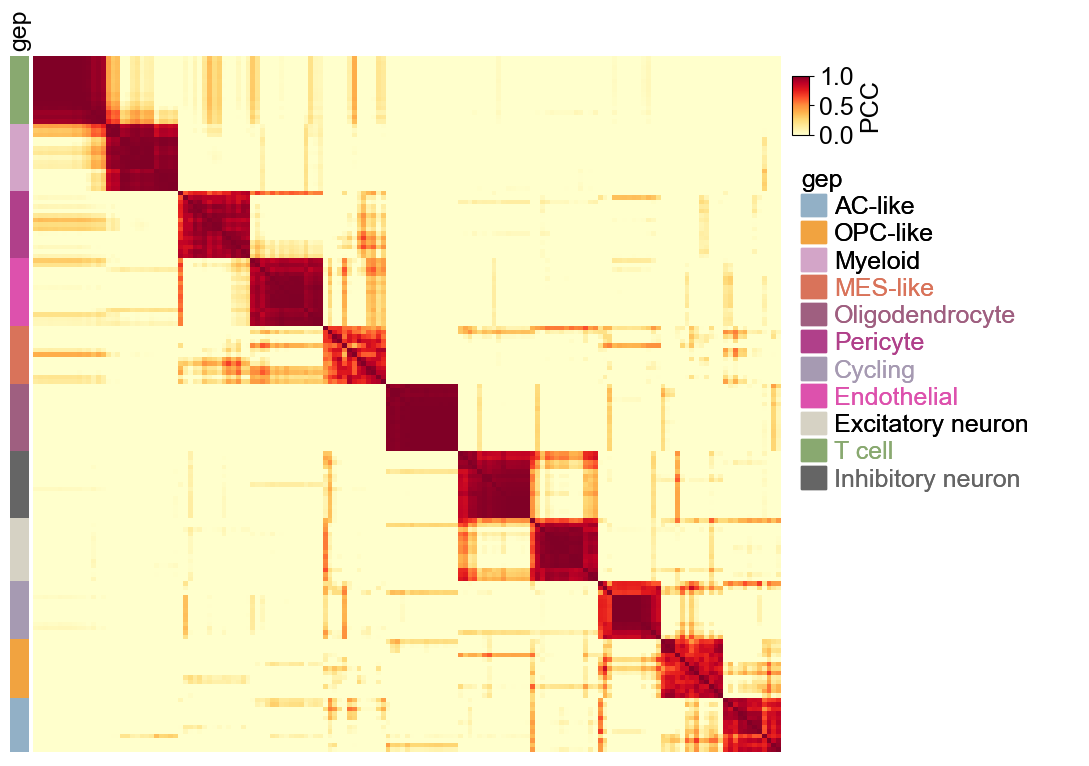

In [ ]:


## remove genes not clustered well
excluded_genes = ['TESPA1','APOE','SERPINA3','TGFB2', 'NCAM1','SOX9']
unique_top15_markers = [x for x in unique_top15_markers if x not in excluded_genes]

topmarkers_dict = top15_markers.to_dict(orient='list')
uniq_topmarkers_dict = {k:list(set(v)-set(duplicated_markers + excluded_genes)) for k,v in top15_markers.to_dict(orient='list').items()}

from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex

gene_spetra_subset = gene_spetra[unique_top15_markers]
gene_program = top15_markers.melt()[['value', 'variable']].drop_duplicates('value').set_index('value').\
    rename(columns={'variable':'gene_program'}).iloc[:, 0].astype('category')
gene_program = gene_program[unique_top15_markers]
# gene_program = pd.Categorical(gene_program, categories=cell_type, ordered=True)
markers_cos_sim = pd.DataFrame(cosine_similarity(gene_spetra_subset.T), index=gene_spetra_subset.columns.tolist(),columns=gene_spetra_subset.columns.tolist())
cmap = plt.get_cmap('Set3')
colors_hex = [to_hex(cmap(i)) for i in range(cmap.N)]
# ordered_colors = {
#     'T cell': '#ccebc5',
#     'Myeloid': '#b3de69',
#     'Pericyte': '#bc80bd',
#     'Endothelial': '#bebada',
#     'MES-like': '#fdb462',
#     'Cycling': '#ffffb3',
#     'OPC-like': '#fccde5',
#     'AC-like': '#8dd3c7',
#     'Oligodendrocyte': '#d9d9d9',
#     'Inhibitory neuron': '#80b1d3',
#     'Excitatory neuron': '#fb8072'
#  }

plt.rcParams.update({'font.family': 'Arial', 'font.size': 18})
row_ha = pch.HeatmapAnnotation(gep =pch.anno_simple(gene_program[markers_cos_sim.index], 
                                                    legend=True,height=5, 
                                                    colors=cell_type_colors,
                                                    legend_kws={'frameon':False}),
                                                    axis=0)
plt.figure(figsize=(10, 8))
hp1 = pch.ClusterMapPlotter(markers_cos_sim,
                            row_cluster=True, 
                      cmap="YlOrRd", 
                      left_annotation=row_ha,
                      label = 'PCC',
                    #   show_rownames=True,
                      vmin=0)
plt.savefig(f'{plot_dir}/Figure5A.png', dpi=300, bbox_inches='tight')

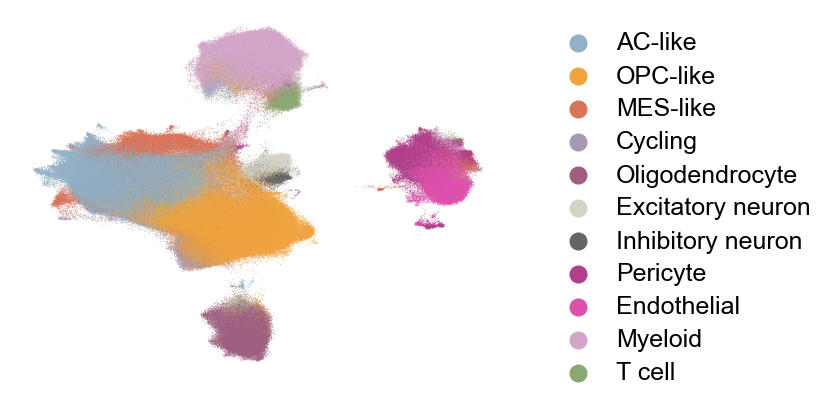

In [21]:
### Figure 5B
# adata.obs['cell_type_final'] = adata.obs['cell_type_final'].astype('category')
adata.obs['cell_type_final'] = pd.Categorical(adata.obs['cell_type_final'],
                                                categories=ordered_celltype,
                                                ordered=True)

plt.rcParams.update({'font.family': 'Arial', 'font.size': 18})
fig, ax = plt.subplots()
sc.pl.umap(adata, color='cell_type_final', s=1, ax=ax, show=False, palette=cell_type_colors)  # Pass the axis and disable automatic display
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_title('')
ax.set_xlabel('')
ax.set_ylabel('')

legend = ax.get_legend()
handles, labels = ax.get_legend_handles_labels()
legend.remove()  # Remove the original legend
ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), frameon=False, 
                       # Horizontal spacing between marker and text
                       handletextpad=0.5,  
                       # Vertical spacing between legend entries
                       labelspacing=0.4,
                       # Size of the legend marker
                       markerscale=2.0)  # Create a new legend with scaled markers and increased distance between markers and text
# Add text annotation of total cell number
# ax.text(0.95, 0.05, f'n = {adata.n_obs}', transform=ax.transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')
fig.savefig(f'{plot_dir}/Figure5B.png', dpi=1000, bbox_inches='tight')
plt.show()


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

OPC-like_Mut vs. OPC-like_WT: Mann-Whitney-Wilcoxon test two-sided, P_val:1.604e-03 U_stat=1.720e+02
MES-like_Mut vs. MES-like_WT: Mann-Whitney-Wilcoxon test two-sided, P_val:2.490e-03 U_stat=2.900e+01
Myeloid_Mut-Codel vs. Myeloid_Mut: Mann-Whitney-Wilcoxon test two-sided, P_val:1.758e-02 U_stat=7.000e+00
Myeloid_Mut vs. Myeloid_WT: Mann-Whitney-Wilcoxon test two-sided, P_val:2.501e-02 U_stat=4.700e+01
OPC-like_Mut-Codel vs. OPC-like_WT: Mann-Whitney-Wilcoxon test two-sided, P_val:4.778e-04 U_stat=1.230e+02
MES-like_Mut-Codel vs. MES-like_WT: Mann-Whitney-Wilcoxon test two-sided, P_val:3.398e-04 U_stat=8.000e+00
Myeloid_Mut-Codel vs. Myeloid_WT: Mann-Whitney-Wilcoxon test two-sided, P_val:2.336e-04 U_stat=7.000e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 <

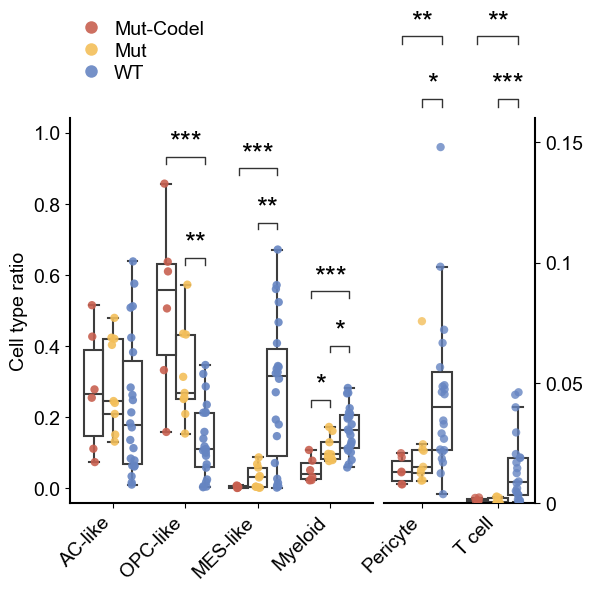

In [45]:
from statannotations.Annotator import Annotator

### Figure 5C
line_width = 1.5
idh_colors = {'Mut-Codel':'#C86050', 'Mut':'#F3BF5A', 'WT':'#6685c2'}
plt.rcParams.update({'font.family': 'Arial', 'font.size': 14})

cell_type_counts = adata.obs.groupby('sample_2')['cell_type_final'].value_counts()
cell_type_ratio = cell_type_counts / cell_type_counts.groupby(level=0).sum()

# Convert the series to a dataframe for easier plotting
cell_type_ratio_df = cell_type_ratio.to_frame().reset_index()
cell_type_ratio_df['idh'] = cell_type_ratio_df['sample_2'].map(adata.obs[['sample_2', 'idh_2']].drop_duplicates().set_index('sample_2')['idh_2'])
cell_type_ratio_df['idh'] = np.where(cell_type_ratio_df['idh'].str.contains('WT'), 'WT', cell_type_ratio_df['idh'])
cell_type_ratio_df['idh'] = pd.Categorical(cell_type_ratio_df['idh'], categories=['Mut-Codel', 'Mut', 'WT'], ordered=True)

selected_df = cell_type_ratio_df[cell_type_ratio_df['cell_type_final'].isin(['AC-like', 'OPC-like', 'MES-like', 'Myeloid', 'Pericyte', 'T cell'])]

selected_df['cell_type_final'] = pd.Categorical(selected_df['cell_type_final'], categories=['AC-like', 'OPC-like', 'MES-like', 'Myeloid', 'Pericyte', 'T cell'], ordered=True)

# Split the data into two groups of cell types
main_celltypes = ['AC-like', 'OPC-like', 'MES-like', 'Myeloid']
other_celltypes = ['Pericyte', 'T cell']

# Create two subplots with reduced spacing
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 5), gridspec_kw={'width_ratios': [2, 1], 'wspace': 0.05})

# Plot main cell types
main_df = selected_df[selected_df['cell_type_final'].isin(main_celltypes)]
main_df['cell_type_final'] = main_df['cell_type_final'].cat.remove_unused_categories()
main_df['cell_type_final'] = main_df['cell_type_final'].cat.reorder_categories(['AC-like', 'OPC-like', 'MES-like', 'Myeloid'], ordered=True)
sns.boxplot(x='cell_type_final', y='count', hue='idh', data=main_df, showfliers=False, ax=ax1, legend=False,
            boxprops={'facecolor':'none', 'linewidth': line_width}, 
            whiskerprops={'linewidth': line_width},
            capprops={'linewidth': line_width},
            medianprops={'linewidth': line_width})
sns.stripplot(x='cell_type_final', y='count', hue='idh', data=main_df, dodge=True, palette=idh_colors, size=6, alpha=0.9, ax=ax1)

# Add significance annotations
box_pairs = [(("AC-like", "Mut-Codel"), ("AC-like", "Mut")),
             (("AC-like", "Mut-Codel"), ("AC-like", "WT")),
             (("AC-like", "Mut"), ("AC-like", "WT")),
             (("OPC-like", "Mut-Codel"), ("OPC-like", "Mut")),
             (("OPC-like", "Mut-Codel"), ("OPC-like", "WT")),
             (("OPC-like", "Mut"), ("OPC-like", "WT")),
             (("MES-like", "Mut-Codel"), ("MES-like", "Mut")), 
             (("MES-like", "Mut-Codel"), ("MES-like", "WT")),
             (("MES-like", "Mut"), ("MES-like", "WT")),
             (("Myeloid", "Mut-Codel"), ("Myeloid", "Mut")),
             (("Myeloid", "Mut-Codel"), ("Myeloid", "WT")),
             (("Myeloid", "Mut"), ("Myeloid", "WT"))]

# Add statistical annotations using Mann-Whitney U test
annotator = Annotator(ax1, pairs=box_pairs, data=main_df, x='cell_type_final', y='count', hue='idh')
annotator.configure(test='Mann-Whitney', text_format='star',line_width=1, loc='inside',hide_non_significant=True, fontsize=20)
annotator.apply_and_annotate()


ax1.set_ylabel('Cell type ratio')
ax1.set_xlabel('')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.legend(title='', bbox_to_anchor=(0.5, 1.3), frameon=False,
           handletextpad=0.2,  
                       # Vertical spacing between legend entries
            labelspacing=0.2,
                       # Size of the legend marker
            markerscale=1.5)
sns.despine(ax=ax1)

# Plot other cell types
other_df = selected_df[selected_df['cell_type_final'].isin(other_celltypes)]
other_df['cell_type_final'] = other_df['cell_type_final'].cat.remove_unused_categories()
other_df['cell_type_final'] = other_df['cell_type_final'].cat.reorder_categories(['Pericyte', 'T cell'], ordered=True)

sns.boxplot(x='cell_type_final', y='count', hue='idh', data=other_df, showfliers=False, ax=ax2,legend=False,
            boxprops={'facecolor': 'none', 'linewidth': line_width}, 
            whiskerprops={'linewidth': line_width},
            capprops={'linewidth': line_width},
            medianprops={'linewidth': line_width})
sns.stripplot(x='cell_type_final', y='count', hue='idh', palette=idh_colors, data=other_df, dodge=True, size=6, alpha=0.8, ax=ax2)
# Draw lines between the boxes for Pericyte and T cell
line_data = other_df.groupby(['cell_type_final', 'idh'])['count'].median().unstack()

ax2.set_ylabel('')
ax2.set_xlabel('')
ax2.set_ylim(0, 0.16)
ax2.set_yticks([0, 0.05, 0.1, 0.15])
ax2.set_yticklabels(['0', '0.05', '0.1', '0.15'])
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.yaxis.set_ticks_position('both')
ax2.yaxis.set_label_position('right')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.legend().remove()  # Remove legend from second subplot
sns.despine(ax=ax2, top=True, right=False, left=True)

# Add significance annotations for other cell types
box_pairs_other = [(("Pericyte", "Mut-Codel"), ("Pericyte", "Mut")), 
                   (("Pericyte", "Mut-Codel"), ("Pericyte", "WT")),
                   (("Pericyte", "Mut"), ("Pericyte", "WT")),
                   (("T cell", "Mut-Codel"), ("T cell", "Mut")), 
                   (("T cell", "Mut-Codel"), ("T cell", "WT")),
                   (("T cell", "Mut"), ("T cell", "WT"))]
annotator = Annotator(ax2, pairs=box_pairs_other, data=other_df, x='cell_type_final', y='count', hue='idh', legend=False)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=2, line_width = 1, hide_non_significant=True,fontsize=20)
annotator.apply_and_annotate()

# Increase the spine linewidth
for spine in ax1.spines.values():
    spine.set_linewidth(line_width)
for spine in ax2.spines.values():
    spine.set_linewidth(line_width)

plt.tight_layout()
fig.savefig(f'{plot_dir}/Figure5C.png', dpi=300, bbox_inches='tight')
